<a href="https://colab.research.google.com/github/amirmohammadkalateh/vanishing-and-exploding-gradient/blob/main/gradient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

# Set random seed for reproducibility
torch.manual_seed(42)

# Create a simple deep neural network
class DeepNN(nn.Module):
    def __init__(self, activation):
        super(DeepNN, self).__init__()
        self.layers = nn.ModuleList([
            nn.Linear(1, 10),
            nn.Linear(10, 10),
            nn.Linear(10, 10),
            nn.Linear(10, 10),
            nn.Linear(10, 1)
        ])
        self.activation = activation

    def forward(self, x):
        gradients = []
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
            gradients.append(x.detach().numpy())
        x = self.layers[-1](x)
        return x, gradients

# Create data
X = torch.linspace(-5, 5, 100).reshape(-1, 1)
y = torch.sin(X)

# Initialize models with different activation functions
model_relu = DeepNN(nn.ReLU())
model_tanh = DeepNN(nn.Tanh())

# Training function
def train_model(model, X, y, learning_rate=0.01, epochs=100):
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    gradient_norms = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        output, gradients = model(X)
        loss = criterion(output, y)
        loss.backward()

        total_norm = 0
        for p in model.parameters():
            if p.grad is not None:
                total_norm += p.grad.data.norm(2).item() ** 2
        total_norm = total_norm ** 0.5
        gradient_norms.append(total_norm)

        optimizer.step()

    return gradient_norms

# Train models and collect gradients
gradient_norms_relu = train_model(model_relu, X, y)
gradient_norms_tanh = train_model(model_tanh, X, y)

# Visualize gradients
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(gradient_norms_relu, label='ReLU')
plt.plot(gradient_norms_tanh, label='Tanh')
plt.title('Gradient Norms During Training')
plt.xlabel('Epoch')
plt.ylabel('Gradient Norm')
plt.legend()
plt.yscale('log')

# Visualize activations
_, gradients_relu = model_relu(X)
_, gradients_tanh = model_tanh(X)

plt.subplot(1, 2, 2)
plt.boxplot([g.flatten() for g in gradients_relu], positions=range(len(gradients_relu)),
           labels=[f'Layer {i+1}' for i in range(len(gradients_relu))], patch_artist=True)
plt.title('Activation Distribution (ReLU)')
plt.xlabel('Layer')
plt.ylabel('Activation Values')

plt.tight_layout()
plt.savefig('gradient_analysis.png')
plt.close()

print("Analysis complete! Check gradient_analysis.png for visualizations.")


<ipython-input-1-96052f7f4eaa>:82: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([g.flatten() for g in gradients_relu], positions=range(len(gradients_relu)),


Analysis complete! Check gradient_analysis.png for visualizations.


# ***newwwwwwwwwwww***

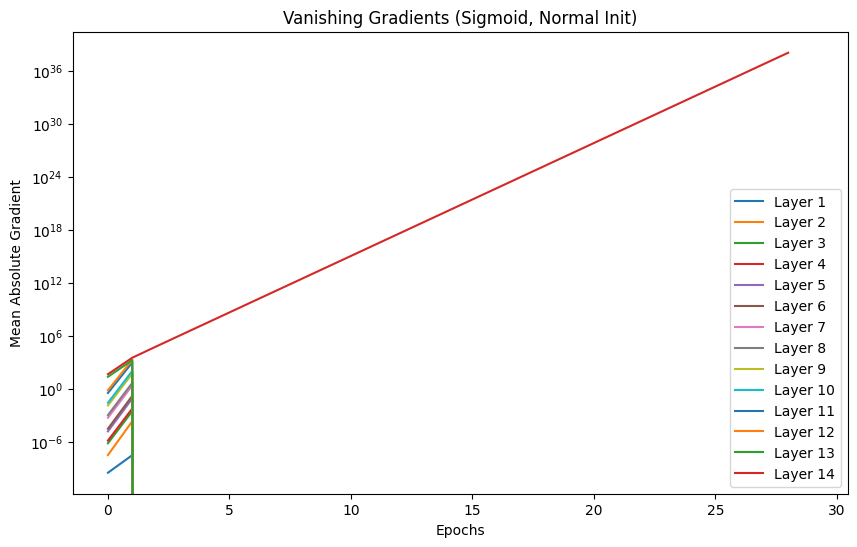

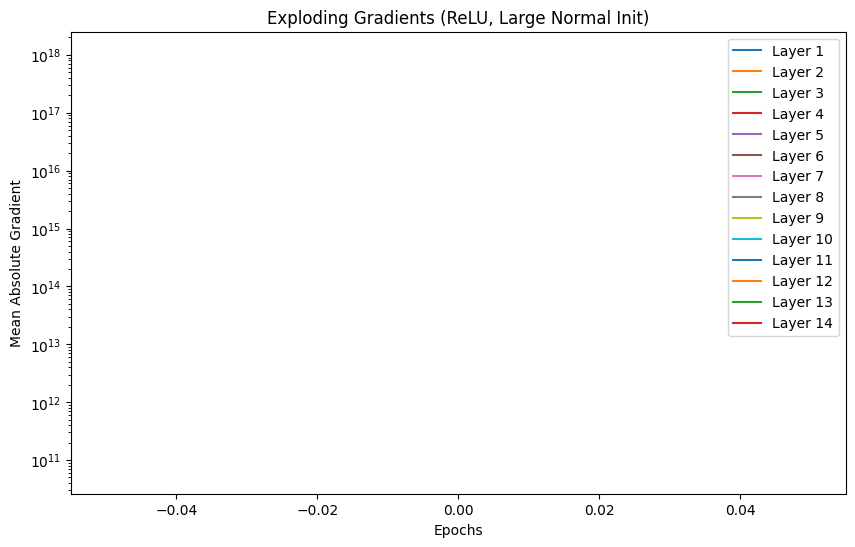

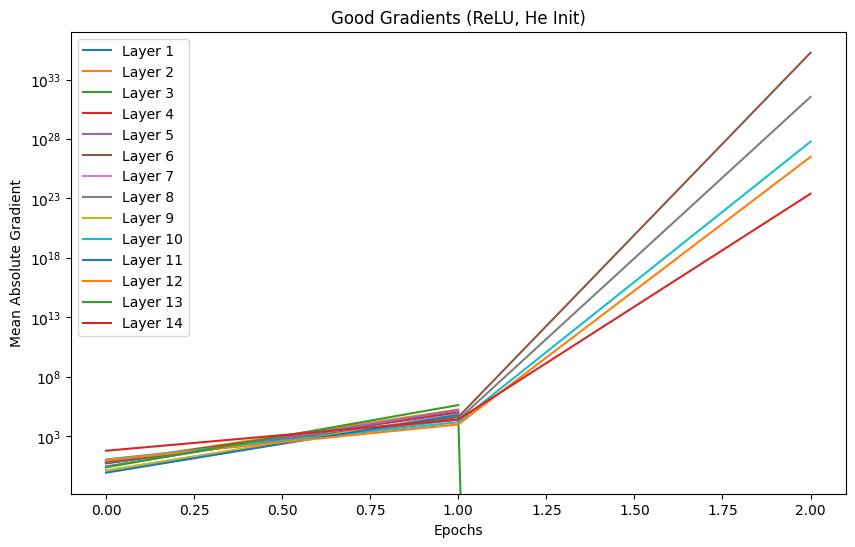

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define the model
def create_model(num_layers, activation='sigmoid', weight_initializer='random_normal'):
    model = keras.Sequential()
    model.add(layers.Dense(10, input_dim=1, kernel_initializer=weight_initializer, activation=activation))
    for _ in range(num_layers):
        model.add(layers.Dense(10, kernel_initializer=weight_initializer, activation=activation))
    model.add(layers.Dense(1, kernel_initializer=weight_initializer))
    return model

# Generate some data
X = np.linspace(-1, 1, 100)
y = X**2 + 0.1 * np.random.randn(100)

# Train the model and track gradients
def train_and_track_gradients(model, X, y, epochs=100):
    optimizer = keras.optimizers.SGD(learning_rate=0.1)
    gradients_history = []

    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            y_pred = model(X.reshape(-1, 1), training=True)
            loss = keras.losses.mse(y, y_pred)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        # Store the mean absolute gradient for each layer
        mean_abs_gradients = [np.mean(np.abs(grad.numpy())) for grad in gradients]
        gradients_history.append(mean_abs_gradients)
    return gradients_history

# Visualize gradients
def visualize_gradients(gradients_history, title):
    plt.figure(figsize=(10, 6))
    for i in range(len(gradients_history[0])):
        plt.plot(range(len(gradients_history)), [g[i] for g in gradients_history], label=f'Layer {i+1}')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Gradient')
    plt.legend()
    plt.yscale('log')
    plt.show()

# Experiment with vanishing gradients (sigmoid, normal initialization)
model_vanishing = create_model(num_layers=5, activation='sigmoid', weight_initializer='random_normal')
gradients_vanishing = train_and_track_gradients(model_vanishing, X, y)
visualize_gradients(gradients_vanishing, 'Vanishing Gradients (Sigmoid, Normal Init)')

# Experiment with exploding gradients (relu, large normal initialization)
model_exploding = create_model(num_layers=5, activation='relu', weight_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=10.0))
gradients_exploding = train_and_track_gradients(model_exploding, X, y)
visualize_gradients(gradients_exploding, 'Exploding Gradients (ReLU, Large Normal Init)')

# Experiment with a good scenario relu and he initialization.
model_good = create_model(num_layers=5, activation='relu', weight_initializer='he_normal')
gradients_good = train_and_track_gradients(model_good, X, y)
visualize_gradients(gradients_good, 'Good Gradients (ReLU, He Init)')
